#  Deep Learning-Based Semantic Segmentation Techniques on Carla Dataset

## Loading libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/thesis/256_np_array /content/np_files

In [3]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [4]:
# Import builtin libraries
import os

In [5]:
#Import third party libraries
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

#same procedure for "froms"
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn
# from torcheval.metrics import MulticlassAccuracy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import center_crop
from torchmetrics.classification import Dice
from torchmetrics import JaccardIndex, Accuracy
from torchmetrics.segmentation import MeanIoU
from tqdm.auto import tqdm



## Set the Random State


In [6]:
torch.manual_seed(1)
# Set numpy random seed, if issues use random state
np.random.seed(1)

## Loading the Data

In [ ]:
# Base directory containing all data parts
base_dir = 'carla-capture'

#list of subdirectories
data_parts = ['dataA', 'dataB', 'dataC', 'dataD', 'dataE']

### obtaining Path

In [ ]:
#making a list to store images
image_paths = []

# Loop through each data part subdirectory
for part in data_parts:
    # Set the directory for images
    datadir_images = os.path.join(base_dir, part, 'CameraRGB/')
    # Load the image paths in a list if the directory exists
    if os.path.exists(datadir_images):
        filenames_images = [name for name in os.listdir(datadir_images) if name.endswith('.png')]
        # Combine the image path with the OS path
        image_paths.extend([os.path.join(datadir_images, filename) for filename in filenames_images])


# for path in image_paths:
#     print(path)
print(len(image_paths))

5000


In [ ]:
# same procedur for labels
label_paths = []

# Loop through each data part subdirectory
for part in data_parts:
    # Set the directory for labels
    datadir_labels = os.path.join(base_dir, part, 'CameraSeg/')
    # Load the label paths in a list if the directory exists
    if os.path.exists(datadir_labels):
        filenames_labels = [name for name in os.listdir(datadir_labels) if name.endswith('.png')]
        # Combine the label path with the OS path
        label_paths.extend([os.path.join(datadir_labels, name) for name in filenames_labels])


# for path in label_paths:
#     print(path)


print(len(label_paths))

5000


## Displaying the data

In [ ]:
# Load images and convert them from BGR to RGB
x = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths]
y = [cv2.imread(path) for path in label_paths]

# Convert Images to numpy array then convert them from BGR to RGB
# Images= np.array(Images)[..., ::-1]

In [ ]:
x = [cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA) for img in x]
y = [cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA) for img in y]

## saving the Data

In [ ]:
# Convert images and labels to numpy arrays
x = np.array(x)
y = np.array(y)


In [ ]:
# x = x.reshape( x.shape[0], x.shape[3], x.shape[1], x.shape[2])
#y = y.reshape( y.shape[0], y.shape[3], y.shape[1], y.shape[2])

x = x.transpose(0, 3, 1, 2)


In [ ]:
#split training and validation_test
x_train, x_valtest, y_train, y_valtest=train_test_split(x, y , test_size= 0.4, random_state= 1)

# Split validation-test to validation AND test
x_val, x_test, y_val, y_test= train_test_split(x_valtest, y_valtest, test_size= 0.5, random_state= 1)

In [ ]:
#saving the data
np.save( "images_train", x_train)
np.save( "labels_train", y_train)
np.save( "images_test", x_test)
np.save( "labels_test", y_test)
np.save( "images_val", x_val)
np.save( "labels_val", y_val)

## Pytroch Data Loading

In [7]:
class loadDatasets(Dataset):
    def __init__(self, image_path, label_path):

        self.image = np.load(image_path)
        self.label= np.load(label_path)

    def __getitem__(self, index):

        x = self.image[index, :, :, :]
        x = torch.tensor(x, dtype=torch.float32)


        y = self.label[index, :, :, :]
        y = np.max(y, axis=2)
        y= torch.tensor(y, dtype=torch.long)

        return x, y

    def __len__(self):
        return len(self.image)

## Defining simple FCN Architecture

In [8]:
class FCN_VGG16(nn.Module):
    def __init__(self, n_class=6):
        super(FCN_VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            # Mistake here as well fixed
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))


        self.layer14 = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=1),
            nn.BatchNorm2d(4096),
            nn.ReLU(inplace=True))
        self.layer15 = nn.Sequential(
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.BatchNorm2d(4096),
            nn.ReLU(inplace=True))
        self.layer16 = nn.Sequential(
            nn.Conv2d(4096, n_class, kernel_size=1),
            nn.BatchNorm2d(n_class),
            nn.ReLU(inplace=True))

        #upsampling
        self.upsample = nn.ConvTranspose2d(n_class, n_class, kernel_size=64, stride=32, padding=0, output_padding=0)



    def forward(self, x):
        h = x
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        x = self.layer14(x)
        x = self.layer15(x)
        x = self.layer16(x)
        x = self.upsample(x)

        crop_height = (x.size()[2] - h.size()[2]) // 2
        crop_width = (x.size()[3] - h.size()[3]) // 2
        x = x[:, :, crop_height:crop_height + h.size()[2], crop_width:crop_width + h.size()[3]].contiguous()

        return x


#fcn_model= FCN_VGG16(n_class=13)


## Training the models

In [9]:
# Create a device variable that checks if your computer has GPU or CPU and uses which is available
device = "cuda" if torch.cuda.is_available() else "cpu"

### Load the data

In [10]:
# Load the training data
train_data = loadDatasets("/content/np_files/images_train.npy",
                          "/content/np_files/labels_train.npy" )
# Load the validation data
val_data= loadDatasets("/content/np_files/images_val.npy",
                       "/content/np_files/labels_val.npy")


In [11]:
# Load the test data
test_data= loadDatasets("/content/np_files/images_test.npy",
                        "/content/np_files/labels_test.npy")

### Creating dataloaders

### Defining variables to make things easy

In [12]:
# definig variables
BATCH_SIZE = 8
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 13
FEATURES= [64, 128, 256, 512, 4096]
EPOCHS= 31

In [13]:
# Create the train data loader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
# Create the validation data loader
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# Create the test data loader
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

### Defining the model

In [16]:
#FCN
fcn_model = FCN_VGG16(n_class= OUTPUT_CHANNELS)

In [17]:
# Move the model to device
fcn_model.to(device)

FCN_VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [18]:
# Define an optimizer
# https://pytorch.org/docs/stable/optim.html
LR= 0.0001
fcn_optimizer = optim.Adam(fcn_model.parameters(), lr=LR)

In [19]:
scaler = torch.cuda.amp.GradScaler()

In [20]:
# Define a loss function
# see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion =torch.nn.CrossEntropyLoss()

### Define metrics

In [21]:
# acc_train =  MulticlassAccuracy().to(device)
miou_train = MeanIoU(num_classes=13, per_class=True, include_background=True).to(device)
dice = Dice(num_classes=13, average='micro').to(device)

# acc_val = MulticlassAccuracy().to(device)
miou_val = MeanIoU(num_classes=13, per_class=True, include_background=True).to(device)


In [22]:
softmax = nn.Softmax(dim=1)

### The trianing !

In [23]:
# Create two lists for training and validation loss 
train_loss=[]
val_loss=[]

# Create two lists for storing mIoU 
train_miou= []
val_miou= []

# Create two lists to store dice score/coefficient (training and validation)
train_dice=[]
val_dice=[]



# Define a function that will have the training code
def train():
  
  # Create a for loop to go over each epoch
  for epoch in range(EPOCHS):
    t_dice= 0
    v_dice=0
    miou=0
    fcn_model_loss=0
    v_miou=0
    fcn_loss_val=0
    # Now we need to go over every batch in data loader
    for image, label in tqdm(train_loader):
      image= image.to(device)
      label= label.to(device)
      # train/update the neural network model

      with torch.cpu.amp.autocast():
        pred = fcn_model(image)
      # get the predictions of the model
      # Compute the loss between prediction and label using loss function
      ### PREDICTION WILL HAVE DIFFERENT SHAPE THEN LABEL
      ### E.G LABEL IS 256x256, PRED IS 488x488
      ### use center_crop(pred[0], (label.shape[2], x.label[3]) )
      ### THE BIGGER IMAGE IS CROPPED AND THE DIMENSIONS ARE OF SMALLER
      # print(pred.shape, label.shape)
        fcn_model_loss= criterion(pred, label)
      # backward
      fcn_optimizer.zero_grad()
      scaler.scale(fcn_model_loss).backward()
      scaler.step(fcn_optimizer)
      scaler.update()

      # # Do a backward pass on your model
      # fcn_model_loss.backward()
      # # Take a step of optimizer
      # fcn_optimizer.step()

    # Put the model in validaton mode, model_variable_name.eval()
    fcn_model.eval()
    # make sure pytorch does not compute gradeients, this can be done as below
    with torch.no_grad():
      for image, label in tqdm(train_loader):
        image= image.to(device)
        label= label.to(device)
        # Get the prediction from the model
        pred= fcn_model(image)
        # Compute the loss between prediction and label using loss function 
        fcn_model_loss= criterion(pred, label)

        pred = torch.argmax(softmax(pred),axis=1)
        # Compute the jaccard index between prediction and label 
        # print(pred.shape, label.shape)
        miou += miou_train(pred, label)

        # compute the dice score between prediction and label 
        t_dice += dice(pred, label).item()

    # Append the loss to the validation loss list
    train_loss.append(fcn_model_loss.item()/len(train_loader))
    # Append the val mIoU (average jaccard index) to val mIoU list
    train_miou.append(miou_train.compute())
    # Append the average accuray to the val accuracy list
    train_dice.append(t_dice/len(train_loader))



    # Print the average val loss
    print(f"The train average loss for {epoch} is: {fcn_model_loss.item()/ len(train_loader)}")
    # Print the val mIoU
    print(f"The train miou for {epoch} is: {train_miou[epoch]}")
    # Print the train accuracy
    print(f"The train dice score for {epoch} is:{train_dice[epoch]}")

    ## reset()
    dice.reset()
    miou_train.reset()

    with torch.no_grad():
      # Go over every batch in validation loader, use for loop
      for image, label in tqdm(val_loader):
        image= image.to(device)
        label= label.to(device)

        # # get the predictions of the model
        pred= fcn_model(image)

        # Compute the loss between prediction and label using loss function
        fcn_loss_val += criterion(pred, label)

        pred = torch.argmax(softmax(pred),axis=1)
        # Compute the jaccard index between prediction and label 
        v_miou += miou_val(pred, label)

        # compute the accuracy between prediction and label
        v_dice += dice(pred, label).item()

    # Append the loss to the validation loss list
    val_loss.append(fcn_loss_val.item()/ len(val_loader))
    # Append the val mIoU (average jaccard index) to val mIoU list
    val_miou.append(miou_val.compute())
    # Append the average accuray to the val accuracy list
    val_dice.append(v_dice/len(val_loader))



    # Print the average val loss
    print(f"The average val loss for {epoch} is: {fcn_loss_val.item()/ len(val_loader)}")
    # Print the val mIoU
    print(f"The val miou for {epoch} is: {miou_val.compute()}")
    # Print the val accuracy
    print(f"The val dice score for {epoch} is:{val_dice[epoch]}")

   ####reset()

    dice.reset()
    miou_val.reset()



    # Save the model after every 10 epochs
    # if epoch % 10 == 0:
    save_path = "Model_Weights/fcn_model/"
    fcn_model_epoch = f"fcn_model_epoch{epoch}.pth"
    # Create a directory if it does not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok = True)
    # Save the model to this directory
    torch.save({'fcn_model_state_dict':fcn_model.state_dict(),
    'fcn_optimizer_state_dict': fcn_optimizer.state_dict()}, save_path + fcn_model_epoch)

In [24]:
# End of function definition
train()

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 0 is: 0.004653167406717936
The train miou for 0 is: tensor([0.6605, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6913, 0.1922,
        0.0648, 0.8681, 0.0000, 0.0000], device='cuda:0')
The train dice score for 0 is:0.6632273915608724


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 0 is: 1.630702880859375
The val miou for 0 is: tensor([0.6668, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6896, 0.1948,
        0.0650, 0.8681, 0.0000, 0.0000], device='cuda:0')
The val dice score for 0 is:0.6665684509277344


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 1 is: 0.001768643061319987
The train miou for 1 is: tensor([8.3275e-01, 3.9278e-01, 1.3067e-04, 1.6591e-06, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 8.4874e-01, 5.9199e-01, 4.1488e-01, 9.3700e-01, 6.1089e-06,
        0.0000e+00], device='cuda:0')
The train dice score for 1 is:0.8264328002929687


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 1 is: 0.6183857421875
The val miou for 1 is: tensor([8.3522e-01, 3.7996e-01, 9.9426e-05, 2.6604e-06, 0.0000e+00, 0.0000e+00,
        5.5675e-06, 8.4687e-01, 5.9381e-01, 4.1384e-01, 9.3696e-01, 1.0571e-06,
        0.0000e+00], device='cuda:0')
The val dice score for 1 is:0.8273883666992188


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 2 is: 0.0015195347468058267
The train miou for 2 is: tensor([8.6165e-01, 5.1080e-01, 2.0699e-02, 3.0526e-03, 0.0000e+00, 2.1535e-06,
        1.8887e-03, 8.7006e-01, 6.4990e-01, 5.3009e-01, 9.4935e-01, 3.4256e-02,
        0.0000e+00], device='cuda:0')
The train dice score for 2 is:0.8579315083821615


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 2 is: 0.4992321472167969
The val miou for 2 is: tensor([8.6376e-01, 4.9657e-01, 2.1538e-02, 2.5449e-03, 0.0000e+00, 2.3310e-06,
        1.9045e-03, 8.6757e-01, 6.5046e-01, 5.2771e-01, 9.4911e-01, 3.3536e-02,
        0.0000e+00], device='cuda:0')
The val dice score for 2 is:0.8582345275878906


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 3 is: 0.0014588424364725748
The train miou for 3 is: tensor([8.7043e-01, 5.4467e-01, 3.4898e-02, 2.4987e-02, 2.5317e-05, 1.3628e-05,
        5.7304e-03, 8.7859e-01, 6.4707e-01, 5.6576e-01, 9.5418e-01, 1.4005e-01,
        0.0000e+00], device='cuda:0')
The train dice score for 3 is:0.8682454274495442


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 3 is: 0.46033160400390627
The val miou for 3 is: tensor([8.7148e-01, 5.2725e-01, 3.4973e-02, 2.1518e-02, 3.2521e-05, 9.9083e-06,
        5.9820e-03, 8.7681e-01, 6.4919e-01, 5.6103e-01, 9.5340e-01, 1.4278e-01,
        0.0000e+00], device='cuda:0')
The val dice score for 3 is:0.8682564697265625


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 4 is: 0.0010890983740488689
The train miou for 4 is: tensor([8.8033e-01, 5.6772e-01, 4.7146e-02, 4.8455e-02, 1.1268e-04, 1.0513e-04,
        9.0765e-02, 8.7545e-01, 6.7588e-01, 5.7945e-01, 9.6425e-01, 1.7384e-01,
        0.0000e+00], device='cuda:0')
The train dice score for 4 is:0.8748705393473307


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 4 is: 0.43497601318359375
The val miou for 4 is: tensor([8.8088e-01, 5.4995e-01, 4.8159e-02, 4.4073e-02, 1.3537e-04, 8.0166e-05,
        9.0299e-02, 8.7384e-01, 6.7738e-01, 5.7326e-01, 9.6361e-01, 1.6750e-01,
        0.0000e+00], device='cuda:0')
The val dice score for 4 is:0.8744675598144531


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 5 is: 0.0011082792282104492
The train miou for 5 is: tensor([8.8938e-01, 5.7827e-01, 7.4436e-02, 6.6367e-02, 3.7752e-04, 9.0336e-04,
        4.1016e-02, 8.8471e-01, 6.9526e-01, 5.9548e-01, 9.6733e-01, 2.1471e-01,
        1.4467e-02], device='cuda:0')
The train dice score for 5 is:0.8813967081705729


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 5 is: 0.4104540100097656
The val miou for 5 is: tensor([8.8969e-01, 5.5991e-01, 7.3936e-02, 5.7731e-02, 3.6682e-04, 1.0681e-03,
        3.9077e-02, 8.8250e-01, 6.9586e-01, 5.8964e-01, 9.6638e-01, 2.0181e-01,
        1.8729e-02], device='cuda:0')
The val dice score for 5 is:0.8807103424072266


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 6 is: 0.0010547547340393067
The train miou for 6 is: tensor([8.8859e-01, 5.8576e-01, 8.9132e-02, 7.9456e-02, 7.3937e-04, 1.7962e-03,
        4.0186e-02, 8.8608e-01, 6.9235e-01, 6.1148e-01, 9.6713e-01, 2.5258e-01,
        3.2172e-02], device='cuda:0')
The train dice score for 6 is:0.8839099629720052


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 6 is: 0.40045205688476565
The val miou for 6 is: tensor([8.8866e-01, 5.6893e-01, 8.9389e-02, 6.8303e-02, 7.8560e-04, 2.0721e-03,
        4.1274e-02, 8.8416e-01, 6.9227e-01, 6.0556e-01, 9.6592e-01, 2.3924e-01,
        3.9808e-02], device='cuda:0')
The val dice score for 6 is:0.8829900360107422


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 7 is: 0.00087656037012736
The train miou for 7 is: tensor([0.8877, 0.6071, 0.0955, 0.1031, 0.0015, 0.0050, 0.0665, 0.8882, 0.7040,
        0.6211, 0.9647, 0.2747, 0.0560], device='cuda:0')
The train dice score for 7 is:0.8876693929036459


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 7 is: 0.3892638549804687
The val miou for 7 is: tensor([0.8874, 0.5871, 0.0957, 0.0875, 0.0017, 0.0058, 0.0658, 0.8863, 0.7035,
        0.6144, 0.9638, 0.2532, 0.0690], device='cuda:0')
The val dice score for 7 is:0.8863967132568359


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 8 is: 0.0011056663195292155
The train miou for 8 is: tensor([0.8985, 0.6130, 0.1069, 0.1308, 0.0032, 0.0095, 0.0416, 0.8866, 0.6918,
        0.6264, 0.9665, 0.2927, 0.0926], device='cuda:0')
The train dice score for 8 is:0.889160405476888


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 8 is: 0.38369436645507815
The val miou for 8 is: tensor([0.8986, 0.5935, 0.1066, 0.1133, 0.0038, 0.0108, 0.0401, 0.8847, 0.6906,
        0.6197, 0.9653, 0.2738, 0.1010], device='cuda:0')
The val dice score for 8 is:0.887708023071289


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 9 is: 0.0011853921413421632
The train miou for 9 is: tensor([0.8983, 0.6218, 0.1120, 0.1434, 0.0046, 0.0110, 0.0764, 0.8926, 0.7127,
        0.6297, 0.9658, 0.3118, 0.1023], device='cuda:0')
The train dice score for 9 is:0.8925251007080078


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 9 is: 0.3732052001953125
The val miou for 9 is: tensor([0.8976, 0.6012, 0.1124, 0.1220, 0.0055, 0.0128, 0.0752, 0.8904, 0.7115,
        0.6234, 0.9644, 0.2912, 0.1116], device='cuda:0')
The val dice score for 9 is:0.8908133392333984


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 10 is: 0.0007880450884501139
The train miou for 10 is: tensor([0.9007, 0.6248, 0.1155, 0.1589, 0.0089, 0.0184, 0.1371, 0.8955, 0.7166,
        0.6344, 0.9712, 0.3234, 0.1097], device='cuda:0')
The train dice score for 10 is:0.8949301554361979


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 10 is: 0.367479736328125
The val miou for 10 is: tensor([0.9002, 0.6031, 0.1149, 0.1387, 0.0105, 0.0217, 0.1338, 0.8933, 0.7146,
        0.6275, 0.9700, 0.3015, 0.1187], device='cuda:0')
The val dice score for 10 is:0.8930776977539062


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 11 is: 0.0011675790150960286
The train miou for 11 is: tensor([0.9029, 0.6309, 0.1211, 0.1540, 0.0112, 0.0242, 0.2055, 0.8997, 0.7111,
        0.6349, 0.9718, 0.3277, 0.1031], device='cuda:0')
The train dice score for 11 is:0.8963618774414063


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 11 is: 0.36432125854492187
The val miou for 11 is: tensor([0.9019, 0.6084, 0.1217, 0.1309, 0.0133, 0.0270, 0.2031, 0.8978, 0.7094,
        0.6274, 0.9705, 0.3012, 0.1151], device='cuda:0')
The val dice score for 11 is:0.894339599609375


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 12 is: 0.0009132785002390544
The train miou for 12 is: tensor([0.8988, 0.6374, 0.1291, 0.1811, 0.0161, 0.0237, 0.2526, 0.9027, 0.7178,
        0.6452, 0.9724, 0.3387, 0.1202], device='cuda:0')
The train dice score for 12 is:0.8987090861002605


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 12 is: 0.35675787353515626
The val miou for 12 is: tensor([0.8979, 0.6155, 0.1301, 0.1581, 0.0193, 0.0279, 0.2504, 0.9004, 0.7158,
        0.6374, 0.9711, 0.3152, 0.1282], device='cuda:0')
The val dice score for 12 is:0.8966733703613281


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 13 is: 0.0009591296513875325
The train miou for 13 is: tensor([0.9026, 0.6400, 0.1303, 0.1851, 0.0170, 0.0258, 0.2758, 0.9069, 0.7269,
        0.6436, 0.9728, 0.3462, 0.1275], device='cuda:0')
The train dice score for 13 is:0.9003925526936849


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 13 is: 0.35285699462890624
The val miou for 13 is: tensor([0.9016, 0.6169, 0.1303, 0.1597, 0.0200, 0.0295, 0.2731, 0.9047, 0.7246,
        0.6349, 0.9714, 0.3239, 0.1349], device='cuda:0')
The val dice score for 13 is:0.8981322784423829


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 14 is: 0.0010052719910939535
The train miou for 14 is: tensor([0.9051, 0.6427, 0.1327, 0.1895, 0.0233, 0.0303, 0.2723, 0.9076, 0.7260,
        0.6462, 0.9738, 0.3441, 0.1252], device='cuda:0')
The train dice score for 14 is:0.9013543904622395


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 14 is: 0.35132086181640626
The val miou for 14 is: tensor([0.9039, 0.6202, 0.1333, 0.1652, 0.0275, 0.0340, 0.2714, 0.9056, 0.7230,
        0.6381, 0.9722, 0.3184, 0.1328], device='cuda:0')
The val dice score for 14 is:0.8990855712890625


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 15 is: 0.0010983209609985352
The train miou for 15 is: tensor([0.9059, 0.6424, 0.1394, 0.1951, 0.0268, 0.0316, 0.2905, 0.9091, 0.7226,
        0.6518, 0.9745, 0.3516, 0.1404], device='cuda:0')
The train dice score for 15 is:0.9022486317952474


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 15 is: 0.3474970703125
The val miou for 15 is: tensor([0.9044, 0.6197, 0.1398, 0.1695, 0.0320, 0.0360, 0.2886, 0.9067, 0.7200,
        0.6437, 0.9729, 0.3280, 0.1400], device='cuda:0')
The val dice score for 15 is:0.8997841491699219


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 16 is: 0.0010855085849761964
The train miou for 16 is: tensor([0.9038, 0.6480, 0.1395, 0.2039, 0.0284, 0.0366, 0.3105, 0.9110, 0.7313,
        0.6542, 0.9739, 0.3546, 0.1425], device='cuda:0')
The train dice score for 16 is:0.9032752888997396


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 16 is: 0.3443970947265625
The val miou for 16 is: tensor([0.9024, 0.6241, 0.1407, 0.1775, 0.0342, 0.0409, 0.3083, 0.9089, 0.7285,
        0.6457, 0.9720, 0.3312, 0.1454], device='cuda:0')
The val dice score for 16 is:0.9007705078125


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 17 is: 0.0013053743044535318
The train miou for 17 is: tensor([0.9060, 0.6540, 0.1414, 0.2052, 0.0280, 0.0369, 0.3103, 0.9117, 0.7317,
        0.6563, 0.9728, 0.3567, 0.1456], device='cuda:0')
The train dice score for 17 is:0.9042492472330729


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 17 is: 0.3419887390136719
The val miou for 17 is: tensor([0.9047, 0.6306, 0.1430, 0.1804, 0.0342, 0.0420, 0.3095, 0.9095, 0.7291,
        0.6479, 0.9711, 0.3326, 0.1496], device='cuda:0')
The val dice score for 17 is:0.9018676147460938


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 18 is: 0.0008632205327351888
The train miou for 18 is: tensor([0.9149, 0.6541, 0.1422, 0.2093, 0.0304, 0.0436, 0.3241, 0.9141, 0.7316,
        0.6475, 0.9741, 0.3630, 0.1459], device='cuda:0')
The train dice score for 18 is:0.9048753662109374


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 18 is: 0.3406441955566406
The val miou for 18 is: tensor([0.9130, 0.6303, 0.1426, 0.1821, 0.0369, 0.0472, 0.3213, 0.9115, 0.7283,
        0.6394, 0.9722, 0.3387, 0.1456], device='cuda:0')
The val dice score for 18 is:0.9021489562988281


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 19 is: 0.000781147321065267
The train miou for 19 is: tensor([0.9099, 0.6527, 0.1484, 0.2171, 0.0339, 0.0429, 0.3245, 0.9139, 0.7346,
        0.6598, 0.9754, 0.3657, 0.1474], device='cuda:0')
The train dice score for 19 is:0.9058318583170573


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 19 is: 0.3387591247558594
The val miou for 19 is: tensor([0.9080, 0.6282, 0.1502, 0.1898, 0.0412, 0.0492, 0.3227, 0.9114, 0.7315,
        0.6500, 0.9735, 0.3398, 0.1525], device='cuda:0')
The val dice score for 19 is:0.9029803009033203


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 20 is: 0.0010124348004659017
The train miou for 20 is: tensor([0.9095, 0.6575, 0.1449, 0.2218, 0.0318, 0.0473, 0.3440, 0.9154, 0.7373,
        0.6597, 0.9747, 0.3699, 0.1480], device='cuda:0')
The train dice score for 20 is:0.9064530436197916


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 20 is: 0.33539447021484375
The val miou for 20 is: tensor([0.9076, 0.6332, 0.1461, 0.1948, 0.0390, 0.0517, 0.3429, 0.9131, 0.7335,
        0.6497, 0.9727, 0.3459, 0.1494], device='cuda:0')
The val dice score for 20 is:0.9035645599365234


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 21 is: 0.001012476682662964
The train miou for 21 is: tensor([0.9048, 0.6553, 0.1498, 0.2298, 0.0372, 0.0501, 0.3435, 0.9152, 0.7360,
        0.6665, 0.9756, 0.3721, 0.1512], device='cuda:0')
The train dice score for 21 is:0.9063934783935547


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 21 is: 0.33671633911132814
The val miou for 21 is: tensor([0.9029, 0.6313, 0.1521, 0.2015, 0.0452, 0.0545, 0.3429, 0.9129, 0.7321,
        0.6568, 0.9739, 0.3458, 0.1558], device='cuda:0')
The val dice score for 21 is:0.9035665893554687


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 22 is: 0.0008866775830586751
The train miou for 22 is: tensor([0.9142, 0.6617, 0.1539, 0.2302, 0.0385, 0.0556, 0.3341, 0.9156, 0.7404,
        0.6582, 0.9763, 0.3758, 0.1578], device='cuda:0')
The train dice score for 22 is:0.9075750376383463


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 22 is: 0.3331410827636719
The val miou for 22 is: tensor([0.9120, 0.6374, 0.1561, 0.2030, 0.0470, 0.0594, 0.3326, 0.9131, 0.7363,
        0.6484, 0.9741, 0.3537, 0.1570], device='cuda:0')
The val dice score for 22 is:0.9045727233886719


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 23 is: 0.0007752013206481933
The train miou for 23 is: tensor([0.9138, 0.6628, 0.1530, 0.2335, 0.0403, 0.0552, 0.3487, 0.9167, 0.7378,
        0.6620, 0.9757, 0.3722, 0.1627], device='cuda:0')
The train dice score for 23 is:0.907920415242513


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 23 is: 0.33241824340820314
The val miou for 23 is: tensor([0.9117, 0.6367, 0.1551, 0.2048, 0.0488, 0.0600, 0.3476, 0.9142, 0.7344,
        0.6528, 0.9736, 0.3468, 0.1656], device='cuda:0')
The val dice score for 23 is:0.9049751586914062


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 24 is: 0.001003084659576416
The train miou for 24 is: tensor([0.9114, 0.6492, 0.1454, 0.2135, 0.0341, 0.0446, 0.3287, 0.9130, 0.7340,
        0.6586, 0.9737, 0.3645, 0.1526], device='cuda:0')
The train dice score for 24 is:0.9055744222005209


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 24 is: 0.33939437866210936
The val miou for 24 is: tensor([0.9096, 0.6253, 0.1470, 0.1873, 0.0422, 0.0496, 0.3291, 0.9105, 0.7305,
        0.6492, 0.9719, 0.3394, 0.1555], device='cuda:0')
The val dice score for 24 is:0.9028087463378907


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 25 is: 0.0007894419034322103
The train miou for 25 is: tensor([0.9144, 0.6661, 0.1532, 0.2382, 0.0407, 0.0556, 0.3458, 0.9163, 0.7378,
        0.6664, 0.9760, 0.3869, 0.1684], device='cuda:0')
The train dice score for 25 is:0.9087997538248698


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 25 is: 0.33003347778320313
The val miou for 25 is: tensor([0.9118, 0.6399, 0.1548, 0.2083, 0.0497, 0.0601, 0.3451, 0.9134, 0.7331,
        0.6561, 0.9735, 0.3593, 0.1654], device='cuda:0')
The val dice score for 25 is:0.9054595947265625


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 26 is: 0.0008121612866719564
The train miou for 26 is: tensor([0.9149, 0.6678, 0.1619, 0.2449, 0.0438, 0.0595, 0.3674, 0.9186, 0.7452,
        0.6695, 0.9775, 0.3900, 0.1664], device='cuda:0')
The train dice score for 26 is:0.9100103658040365


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 26 is: 0.3283719482421875
The val miou for 26 is: tensor([0.9121, 0.6409, 0.1632, 0.2134, 0.0526, 0.0621, 0.3644, 0.9155, 0.7400,
        0.6587, 0.9749, 0.3635, 0.1655], device='cuda:0')
The val dice score for 26 is:0.9063771362304688


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 27 is: 0.0008304566542307536
The train miou for 27 is: tensor([0.9165, 0.6692, 0.1600, 0.2436, 0.0446, 0.0634, 0.3682, 0.9194, 0.7448,
        0.6667, 0.9765, 0.3867, 0.1730], device='cuda:0')
The train dice score for 27 is:0.910136973063151


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 27 is: 0.3281068115234375
The val miou for 27 is: tensor([0.9136, 0.6424, 0.1619, 0.2120, 0.0533, 0.0664, 0.3661, 0.9166, 0.7397,
        0.6558, 0.9740, 0.3610, 0.1692], device='cuda:0')
The val dice score for 27 is:0.9065324249267578


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 28 is: 0.0006668616135915121
The train miou for 28 is: tensor([0.9140, 0.6664, 0.1578, 0.2452, 0.0456, 0.0639, 0.3684, 0.9193, 0.7466,
        0.6724, 0.9775, 0.3841, 0.1726], device='cuda:0')
The train dice score for 28 is:0.9102283833821615


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 28 is: 0.3270314331054687
The val miou for 28 is: tensor([0.9115, 0.6398, 0.1605, 0.2146, 0.0544, 0.0656, 0.3665, 0.9162, 0.7414,
        0.6609, 0.9752, 0.3559, 0.1697], device='cuda:0')
The val dice score for 28 is:0.9066392059326172


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 29 is: 0.0006244757175445557
The train miou for 29 is: tensor([0.9142, 0.6690, 0.1611, 0.2486, 0.0457, 0.0703, 0.3626, 0.9193, 0.7452,
        0.6723, 0.9768, 0.3902, 0.1675], device='cuda:0')
The train dice score for 29 is:0.9104963633219401


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 29 is: 0.3263511962890625
The val miou for 29 is: tensor([0.9115, 0.6424, 0.1633, 0.2183, 0.0549, 0.0719, 0.3601, 0.9164, 0.7402,
        0.6615, 0.9743, 0.3591, 0.1641], device='cuda:0')
The val dice score for 29 is:0.9069080200195313


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 30 is: 0.0010557441711425781
The train miou for 30 is: tensor([0.9171, 0.6725, 0.1606, 0.2469, 0.0469, 0.0711, 0.3665, 0.9197, 0.7440,
        0.6687, 0.9774, 0.3910, 0.1733], device='cuda:0')
The train dice score for 30 is:0.9107589975992838


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 30 is: 0.32556640625
The val miou for 30 is: tensor([0.9141, 0.6457, 0.1631, 0.2142, 0.0558, 0.0718, 0.3643, 0.9169, 0.7394,
        0.6582, 0.9750, 0.3618, 0.1714], device='cuda:0')
The val dice score for 30 is:0.9071587677001953


In [25]:
save_path = "Model_lists/fcn_model/"

# Create a directory if it does not exist
if not os.path.exists(save_path):
    os.makedirs(save_path, exist_ok = True)

import pickle
with open( save_path + "train_miou", "wb") as fp:   #Pickling
  a= pickle.dump(train_miou, fp)
with open(save_path + "val_miou", "wb") as fp:
  b = pickle.dump(val_miou, fp)

with open(save_path + "train_dice", "wb") as fp:
  b = pickle.dump(train_dice, fp)

with open(save_path + "val_dice", "wb") as fp:
  b = pickle.dump(val_dice, fp)


In [26]:
!cp /content/Model_lists -r /content/drive/MyDrive/thesis/Model_lists

In [27]:
!cp /content/Model_Weights -r /content/drive/MyDrive/thesis/Model_Weights

# Generate masks

In [ ]:
# Get a back of images and labels
batch_img, batch_label = next(iter(train_loader))

In [ ]:
# Get one image and one label from the batch of images and labels
img = batch_img[0]
label = batch_label[0]

In [ ]:
# Change shape from (3, 60, 80) to (1, 3, 60, 80) so our pytorch neural network does not throw a shape error
# shape error meaning: expected 4D input got 3D instead
img = img.unsqueeze(0)

In [ ]:
# Generate a prediction
pred = fcn_model(img.to(device))

In [ ]:
# Change shape of prediction from (1, 13, 60, 80) to (13, 60, 80)
pred = pred.squeeze()

In [ ]:
softmax = nn.Softmax(dim=0)
pred= torch.argmax(softmax(pred), dim=0)

In [ ]:
# Convert the prediction from pytorch tensor to numpy array
pred = pred.detach().cpu()

In [ ]:
# Change shape for prediction from (13, 60, 80) to (60, 80, 13)
# pred = pred.transpose(1,2,0)

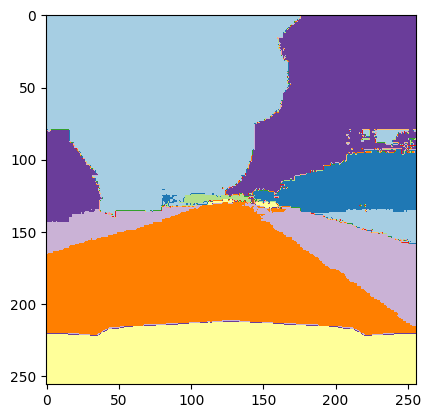

In [ ]:
# Do np.max along last dimension, in our case it 13 for 13 classes
# This give us now a shape of (60, 80), since we took max along 13

# pred= torch.argmax(softmax(pred), dim=0)
# Finally display the mask
plt.imshow(pred, cmap="Paired")


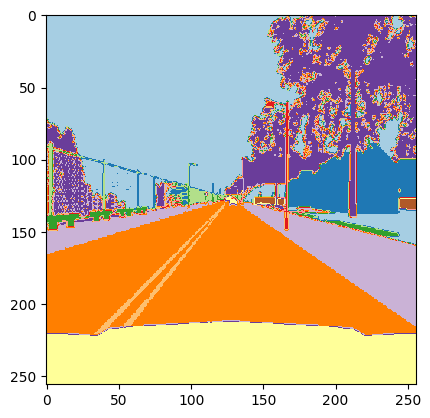

In [ ]:
plt.imshow(label, cmap="Paired")

In [28]:
# acc_train =  MulticlassAccuracy().to(device)
miou_test = MeanIoU(num_classes=13, per_class=True, include_background=True).to(device)
dice = Dice(num_classes=13, average='micro').to(device)




# Testing


1.  Connect to google drive
2.  cp the Model_Weights/fcn_model folder
3. Initialize the model (training code without training)
4. Load the model state dict
5. Then run the test loop








In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [29]:
!cp  /content/drive/MyDrive/thesis/Model_Weights -r /content


#then class loadDatasets(Dataset):

In [31]:
#step_4:
model_save_path = '/content/Model_Weights/fcn_model/fcn_model_epoch30.pth'
model_save_dic= torch.load(model_save_path )
fcn_model.load_state_dict(model_save_dic['fcn_model_state_dict'])

<All keys matched successfully>

In [32]:
fcn_model.eval()
fcn_loss_test=0
miout= 0
dicet=0

with torch.no_grad():

  # Go over every batch in test loader, use for loop
  for image, label in tqdm(test_loader):
    image= image.to(device)
    label= label.to(device)

    # get the predictions of the model
    pred= fcn_model(image)

    # Compute the loss between prediction and label using loss function 
    fcn_loss_test += criterion(pred, label)

    pred = torch.argmax(softmax(pred),axis=1)
    # Compute the jaccard index between prediction and label using jaccard index function 
    miout += miou_test(pred, label)

    # compute the accuracy between prediction and label 
    dicet += dice(pred, label).item()

# Append the loss to the validation loss list
print(fcn_loss_test.item()/ len(test_loader))
#printing the test mIoU (average jaccard index) to val mIoU list
print(f"the mean IOU {miou_test.compute()}")

# printing the average dice to the test accuracy list
print(f" the dice coefficient is {dicet/len(test_loader)}")






  0%|          | 0/125 [00:00<?, ?it/s]

0.3339744873046875
the mean IOU tensor([0.9101, 0.6636, 0.1431, 0.2136, 0.0366, 0.0533, 0.3553, 0.9167, 0.7304,
        0.6549, 0.9734, 0.3521, 0.1487], device='cuda:0')
 the dice coefficient is 0.9046156768798828


# Generate masks

In [33]:
# Get a back of images and labels
batch_img, batch_label = next(iter(test_loader))

In [34]:
# Get one image and one label from the batch of images and labels
img = batch_img[0]
label = batch_label[0]

In [35]:
# Change shape from (3, 60, 80) to (1, 3, 60, 80) so our pytorch neural network does not throw a shape error
# shape error meaning: expected 4D input got 3D instead
img = img.unsqueeze(0)

In [36]:
# Generate a prediction
pred = fcn_model(img.to(device))

In [37]:
# Change shape of prediction from (1, 13, 60, 80) to (13, 60, 80)
pred = pred.squeeze()

In [38]:
softmax = nn.Softmax(dim=0)
pred= torch.argmax(softmax(pred), dim=0)

In [39]:
# Convert the prediction from pytorch tensor to numpy array
pred = pred.detach().cpu()

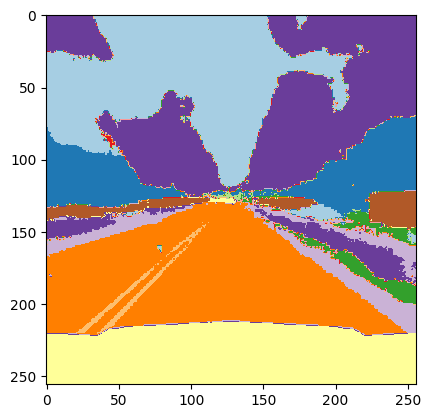

In [40]:
# Finally display the mask
plt.imshow(pred, cmap="Paired")

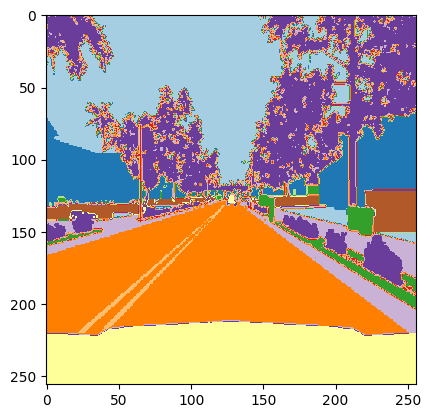

In [41]:
plt.imshow(label, cmap="Paired")